In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge,RidgeCV, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MaxAbsScaler , FunctionTransformer
import scipy
from allennlp.data.tokenizers import SpacyTokenizer
import matplotlib.pyplot as plt
import gc
import re

data_dir = '../data/'

In [3]:
df = pd.read_csv(data_dir+"jigsaw-toxic-comment-classification-challenge/train.csv")

In [4]:
# count the number of toxic/bad labels for different classes
# I assume the rarer this class could be bad, the more weights I should assign 
# since annotators reasonably mark toxics rarely for severe indications
# for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
#     print(col, ':  ', (df[col] == 1).sum())

df['severe_toxic'] = df.severe_toxic * 3
df['threat'] = df.threat * 2
df['identity_hate '] = df.identity_hate * 2

df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})

# Reduce the rows with 0 toxicity 
df = pd.concat([df[df.y>0] , 
                df[df.y==0].sample(int(len(df[df.y>0])*1.5)) ], axis=0).sample(frac=1)


40562

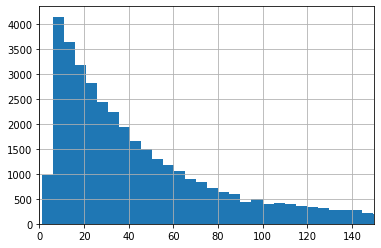

In [17]:
# check text lengths 
batch_tokens = SpacyTokenizer().batch_tokenize(list(df.text))
token_lens = pd.Series([len(tokens) for tokens in batch_tokens])
token_lens.hist(bins=1000)
plt.xlim((0,150))
len(batch_tokens)

In [ ]:

# clean
def clean(data, col):

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters
    data[col] = data[col].str.replace(r'(")\1+',r'\1')    
    data[col] = data[col].str.replace(r'([*!?\'])\1\1+\B',r'\1\1')    
    data[col] = data[col].str.replace(r'(\w)\1\1+\B',r'\1\1')    # Hmmmm -> Hmmm ; *the mooose* -> *the moose*; OOOOOOOOOOH -> OOH; commmunity -> community
    # data[col] = data[col].str.replace(r'(\w)\1+\b',r'\1').str.strip() #  possess -> posses
    data[col] = data[col].str.replace(r'(\w)\1\1+\b',r'\1\1').str.strip() #  possess -> posses
    
    return data

df = clean(df, 'text')

print(df['y'].value_counts())
print(df.shape)

In [11]:
# pipline
pipeline = Pipeline([
        ("vect", FeatureUnion([
                ("vect1", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
                ("vect2", TfidfVectorizer(min_df= 2, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{6,}\b')),
            ])
        ),
        ("clf", Ridge(alpha=1 )),
    ])

pipeline.fit(df['text'], df['y'])

# What are the important features for toxicity
# print('Total number of features:', len(pipeline['vect'].get_feature_names()) )
feature_wt = list(zip(pipeline['vect'].get_feature_names(), np.round(pipeline['clf'].coef_,2) ))
feature_wts = sorted(feature_wt, 
                     key = lambda x:x[1], 
                     reverse=True)

# feature_wts[:10]
# Extract top features from Ridge model 
f1_lst = [x.replace('vect1__','') for x,y in feature_wts[:2000] if (x.startswith('vect1__')) & (len(x.replace('vect1__','').strip())>1)]
f2_lst = [x.replace('vect2__','') for x,y in feature_wts[:2000] if (x.startswith('vect2__'))]
print(len(f1_lst),len(f2_lst))
print(f1_lst[:10])
print(f2_lst[:10])

1250 736
['uck', 'fuc', 'fuck', ' kil ', 'ck ', 'fag', ' f*', ' die', 'kil ', '!! ']
['malaysians', 'niggaz', 'nl33ers', 'motherfuckin', 'cracka', 'wheelchair', 'gardening', 'islams', 'nihgga', 'hookers']


In [13]:
# pipelin1b
pipeline1b = Pipeline(
    [
        ("vect",  FeatureUnion([
            ("vect1", TfidfVectorizer(analyzer = 'char_wb', vocabulary = f1_lst, ngram_range = (3,5))),
            ("vect2", TfidfVectorizer(analyzer = 'word', token_pattern=r'(?u)\b\w{6,}\b', vocabulary = f2_lst)),
            #('count', FunctionTransformer(lambda x: np.array([len(t) for t in x]).reshape(-1, 1), validate=False)),
            ])
        ),
        #('scale', MaxAbsScaler()),
        ("clf", RandomForestRegressor(n_estimators = 50, min_samples_leaf = 3)),
        #("clf", RidgeCV(alphas=(2,1), cv = 3 )),
    ]
)
pipeline1b.fit(df['text'], df['y'])
# print(len(pipeline1b['vect'].get_feature_names())) # 1986
feature_wts1b = sorted(list(zip(pipeline['vect'].get_feature_names(), 
                              np.round(pipeline1b['clf'].feature_importances_,2) )), 
                     key = lambda x:x[1], 
                     reverse=True)

feature_wts1b[:30]

[('vect1__ !!', 0.24),
 ('vect1__ ! ', 0.17),
 ('vect1__ !@#$', 0.03),
 ('vect1__ "(r', 0.03),
 ('vect1__ ", ', 0.03),
 ('vect1__ !!"', 0.02),
 ('vect1__ "jos', 0.02),
 ('vect1__ !!!i', 0.01),
 ('vect1__ !!" ', 0.01),
 ('vect1__ !=', 0.01),
 ('vect1__ " ', 0.01),
 ('vect1__ "\'', 0.01),
 ('vect1__ "(a', 0.01),
 ('vect1__ ") ', 0.01),
 ('vect1__ "***', 0.01),
 ('vect1__ "+', 0.01),
 ('vect1__ "1', 0.01),
 ('vect1__ "201', 0.01),
 ('vect1__ "3.', 0.01),
 ('vect1__ "::', 0.01),
 ('vect1__ "bra', 0.01),
 ('vect1__ "lik', 0.01),
 ('vect1__ "oba', 0.01),
 ('vect1__ "sod', 0.01),
 ('vect1__ "thu', 0.01),
 ('vect1__ !! ', 0.0),
 ('vect1__ !!!', 0.0),
 ('vect1__ !"', 0.0),
 ('vect1__ !" ', 0.0),
 ('vect1__ != ', 0.0)]

In [14]:
del df, feature_wts, feature_wts1b
gc.collect()

70

# Validate the pipeline 

In [15]:
df_val = pd.read_csv(data_dir+"jigsaw-toxic-severity-rating/validation_data.csv")
print(df_val.shape)

df_val = clean(df_val, 'less_toxic')
df_val = clean(df_val, 'more_toxic')


(30108, 3)


/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
/home/xinzhel/.pyenv/versions/3.7.9/envs/allennlp-dev/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The default value of regex will change from True to False in a future

### Model 1

In [16]:
p1 = pipeline.predict(df_val['less_toxic'])
p2 = pipeline.predict(df_val['more_toxic'])

f'Validation Accuracy from Model 1 is { np.round((p1 < p2).mean() * 100,2)}'

'Validation Accuracy from Model 1 is 68.25'

### Model 2

In [17]:
p3 = pipeline1b.predict(df_val['less_toxic'])
p4 = pipeline1b.predict(df_val['more_toxic'])

f'Validation Accuracy from Model 2 is { np.round((p3 < p4).mean() * 100,2)}'

'Validation Accuracy from Model 2 is 68.21'

## Model1 + Model2
### Start with scaling the predictions first before combining

In [27]:
print(np.hstack([p1,p2]).reshape(-1, 1).max())
print(np.hstack([p1,p2]).reshape(-1, 1).min())
print(np.hstack([p1,p2]).reshape(-1, 1).mean())

scale1 = StandardScaler()
scale2 = StandardScaler()

scale1.fit(np.hstack([p1,p2]).reshape(-1,1))
scale2.fit(np.hstack([p3,p4]).reshape(-1,1))

StandardScaler()

In [28]:
# less toxic
p5 = scale1.transform(p1.reshape(-1,1)) + scale2.transform(p3.reshape(-1,1))
# more toxic
p6 = scale1.transform(p2.reshape(-1,1)) + scale2.transform(p4.reshape(-1,1))

f'Validation Accuracy from Model 2 is { np.round((p5 < p6).mean() * 100,2)}'

'Validation Accuracy from Model 2 is 68.92'

In [29]:
# Analyze bad predictions 
### Incorrect predictions with similar scores
### Incorrect predictions with different scores
df_val['p1'] = p5
df_val['p2'] = p6
df_val['diff'] = np.abs(p6 - p5)

df_val['correct'] = (p5 < p6).astype('int')


### Where does most misclassification happen

#### Most come from similar predictions from less toxic comments

In [31]:
# Comparing prediction differences between less toxic and more toxic sentences
df_val = df_val.assign(diff_grp = lambda x: np.ceil(df_val['diff']),
              s1_grp = lambda x: np.ceil(df_val['p1']),
             )

df_val.head()

,worker,less_toxic,more_toxic,p1,p2,diff,correct,diff_grp,s1_grp
0,313,This article sucks wo wo wo,WHAT!!?!?!!?!?!!?!?!?!?!!??!!= WHER IS YOUR SE...,0.696097,-0.527994,1.224091,0,2.0,1.0
1,188,"""And yes, people should recognize that but the...",Daphne Guinnes Top of the mornin' my favouri...,-1.815879,-0.042837,1.773042,1,2.0,-1.0
2,82,"Western Media? Yup, because every crime in th...","""Atom you don't believe actual photos of mastu...",-0.774369,-0.198538,0.575831,1,1.0,-0.0
3,347,And you removed it! You numbskul! I don't care...,You seem to have sand in your vagina. Might w...,-0.592996,2.988408,3.581404,1,4.0,-0.0
4,539,smelly vagina Bluerasberry why don't you be ...,"hey way to support nazis, you racist",0.251777,0.885533,0.633756,1,1.0,1.0


In [32]:

display(
    df_val[df_val.correct == 0]\
    .groupby(['s1_grp']).size().reset_index()\
    .set_axis(['s1_grp','cnt'],axis='columns')\
    .sort_values('cnt', ascending=False)[:15]
)
display(
    df_val[df_val.correct == 0]\
    .groupby(['diff_grp']).size().reset_index()\
    .set_axis(['diff_grp','cnt'],axis='columns')\
    .sort_values('cnt', ascending=False)[:15]
)

display(
    df_val[df_val.correct == 0]\
    .groupby(['s1_grp','diff_grp']).size().reset_index()\
    .set_axis(['s1_grp','diff_grp','cnt'],axis='columns')\
    .sort_values('cnt', ascending=False)[:15]
)

,s1_grp,cnt
2,-0.0,3135
1,-1.0,2167
3,1.0,1641
4,2.0,993
5,3.0,663
6,4.0,326
7,5.0,229
8,6.0,117
9,7.0,51
10,8.0,22


,diff_grp,cnt
0,1.0,5311
1,2.0,2184
2,3.0,913
3,4.0,478
4,5.0,232
5,6.0,136
6,7.0,72
7,8.0,24
8,9.0,6
9,10.0,2


,s1_grp,diff_grp,cnt
3,-0.0,1.0,2185
1,-1.0,1.0,2134
4,-0.0,2.0,930
7,1.0,2.0,746
6,1.0,1.0,571
12,2.0,3.0,349
8,1.0,3.0,320
11,2.0,2.0,246
10,2.0,1.0,229
18,3.0,4.0,192


#### Some of these just look incorrectly tagged 


In [35]:
# Incorrect predictions with similar scores
# df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)
# Incorrect predictions with dis-similar scores
# df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

## Analyze the vocabulary of misclassified sentences 

In [ ]:
# #df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20).more_toxic.tolist()
# comm=df_val.more_toxic[29057]
# print(comm)
# print(vect_an(comm))
# [v for v in vect_an(comm) if (v not in vocab) & (v.strip() not in obj.stop_words_)]
# vect_an(comm)


In [ ]:
# Load TFIDF vectorizer
obj = pipeline["vect"].transformer_list[0][1]; print(obj)
vect_an = obj.build_analyzer()
vocab = obj.vocabulary_
print(len(vocab))

obj2 = pipeline["vect"].transformer_list[1][1]; print(obj)
vect_an2 = obj2.build_analyzer()
vocab2 = obj2.vocabulary_

tmp=[]
for comm in df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20).more_toxic.tolist():
    tmp.append((comm, vect_an(comm), vect_an2(comm)))
pd.DataFrame(tmp, columns = ["comment", "tokenized1", "tokenized2"])

# Predict on test data 

In [ ]:
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")


In [ ]:
# Predict using pipeline
df_sub = clean(df_sub, 'text')

m1_preds = pipeline.predict(df_sub['text'])
m2_preds = pipeline1b.predict(df_sub['text'])

df_sub['score'] = scale1.transform(m1_preds.reshape(-1,1)) + scale2.transform(m2_preds.reshape(-1,1))

## Correct the rank ordering

In [ ]:
# Cases with duplicates scores

df_sub['score'].count() - df_sub['score'].nunique()

In [ ]:
df_sub['score'].value_counts().reset_index()[:10]

In [ ]:
# Rank the predictions 

df_sub['score']  = scipy.stats.rankdata(df_sub['score'], method='ordinal')

print(df_sub['score'].rank().nunique())

In [ ]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)

In [ ]:
test = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')
test['score'] = df_sub.score.tolist()

In [ ]:
test.sort_values('score',ascending=False).head(20)

In [ ]:
test.sort_values('score',ascending=True).head(20)